In [9]:
%pylab inline
from pyspark import SparkContext, SparkConf
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix
np.set_printoptions(precision=3, suppress=True)
import numpy as np
import os
import time

# Custom functions for the task.
from VAT import VAT
from iVAT import iVAT
from dissimilarity import dissimilarity
from clusivatSampling import clusivatSampling

start_time = time.time()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# INPUTS TO ALGORITHM
setSelector = 0 # This number selects a UCR time series. 76 is a big one.
clustEstimate = 10            # Initial guess of number of clusters.
sampleRatio = 1.0
metric = 'euc'

# If checking algorithmic performance all additional printing, figure display
# options will be removed.
test_run = True
optimised = True
save_pics = True

# Data input - assumes this is done externally - not considered part of complexity.
datapath = 'UCR_TS_Archive_2015/'
datadirlist = os.listdir(datapath)
datadirlist.sort()
datadir = datapath+datadirlist[setSelector]+'/'
datafile = [i for i in os.listdir(datadir) if 'TEST' in i]
f = file(datadir+datafile[0])

for i in range(len(datadirlist)):
    print i, datadirlist[i]

0 50words
1 Adiac
2 ArrowHead
3 Beef
4 BeetleFly
5 BirdChicken
6 CBF
7 Car
8 ChlorineConcentration
9 CinC_ECG_torso
10 Coffee
11 Computers
12 Cricket_X
13 Cricket_Y
14 Cricket_Z
15 DiatomSizeReduction
16 DistalPhalanxOutlineAgeGroup
17 DistalPhalanxOutlineCorrect
18 DistalPhalanxTW
19 ECG200
20 ECG5000
21 ECGFiveDays
22 Earthquakes
23 ElectricDevices
24 FISH
25 FaceAll
26 FaceFour
27 FacesUCR
28 FordA
29 FordB
30 Gun_Point
31 Ham
32 HandOutlines
33 Haptics
34 Herring
35 InlineSkate
36 InsectWingbeatSound
37 ItalyPowerDemand
38 LargeKitchenAppliances
39 Lighting2
40 Lighting7
41 MALLAT
42 Meat
43 MedicalImages
44 MiddlePhalanxOutlineAgeGroup
45 MiddlePhalanxOutlineCorrect
46 MiddlePhalanxTW
47 MoteStrain
48 NonInvasiveFatalECG_Thorax1
49 NonInvasiveFatalECG_Thorax2
50 OSULeaf
51 OliveOil
52 PhalangesOutlinesCorrect
53 Phoneme
54 Plane
55 ProximalPhalanxOutlineAgeGroup
56 ProximalPhalanxOutlineCorrect
57 ProximalPhalanxTW
58 RefrigerationDevices
59 ScreenType
60 ShapeletSim
61 ShapesAll


In [3]:
# Array of time series data. This is a poor way of doing it because it means the series must be 
# strorable in memory before being converted to a RDD.
ts = np.genfromtxt(f, delimiter = ',')
numSeries = len(ts)
numSamples = np.ceil(numSeries * sampleRatio)
lenSeries = len(ts[0,1:])
lenSeriesPow2 = np.power(2,int(np.ceil(np.log2(lenSeries))))
timeSeries = [i for i in range(numSeries)]
for i in range(numSeries):
    timeSeries[i] = i, np.append(ts[i,1:], np.zeros(lenSeriesPow2-lenSeries))
    
# Indicates initial setup has been performed and data loaded from file.
preprocessing_time = time.time()

In [4]:
# Partitioning component.

# This is actually not the preferred way of distributing data - as we have actually sent this data across all 
# nodes and are just waiting for it to be acted on - in practise this is wasteful.
if optimised:
    timeSeriesRDD = sc.parallelize(timeSeries,numSlices=3)
else:
    timeSeriesRDD = sc.parallelize(timeSeries)

In [5]:
# Create RDD consisting of indexed dissimilarity arrays of each time series.
# Can select 'euclidian', 'NCC', or 'DTW' as distance metric.
tsDissimRDD = dissimilarity(timeSeriesRDD,numSeries=numSeries,metric=metric)

dissim_mat_time = time.time()

Incorrect metric - default to NCC


In [6]:
clusiVATcheck = True

In [7]:
# Downsample the RDD with given ratio and initial overestimate of cluster count.
sampleIndex, tsDissimMatrixSampled = clusivatSampling(tsDissimRDD,clustEstimate,sampleRatio,clusterCount = False)

if clusiVATcheck and sampleRatio != 1.0:
    _, tsDissimMatrixFull = clusivatSampling(tsDissimRDD,clustEstimate,sampleRatio=1.0,clusterCount = False)

sample_time = time.time()

In [8]:
D_iVAT, D_VAT, I_VAT, C, d = iVAT(tsDissimMatrixSampled)

## RESULTS

In [9]:
iVAT_develop = time.time()

pre_time = preprocessing_time - start_time
build_dissim_mat = dissim_mat_time - preprocessing_time
produce_sample_matrix = sample_time - dissim_mat_time
iVAT_development_time = iVAT_develop - sample_time
totalruntime = iVAT_develop - start_time

print("Pre-processing time = %s seconds" % pre_time)
print("Unordered dissimilarity matrix development = %s seconds" % build_dissim_mat)
print("Produce sampled matrix =  %s seconds" % produce_sample_matrix)
print("iVAT developement time =  %s seconds" % iVAT_development_time)
print("Total runtime =  %s seconds" % totalruntime)

Pre-processing time = 0.106009960175 seconds
Unordered dissimilarity matrix development = 0.648855924606 seconds
Produce sampled matrix =  40.41031003 seconds
iVAT developement time =  3.38031506538 seconds
Total runtime =  44.5454909801 seconds


There are 1029 series and 24 samples per series in the 'ItalyPowerDemand' dataset.


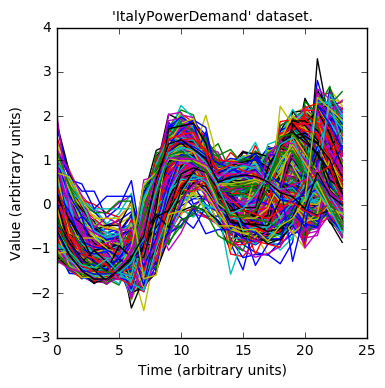

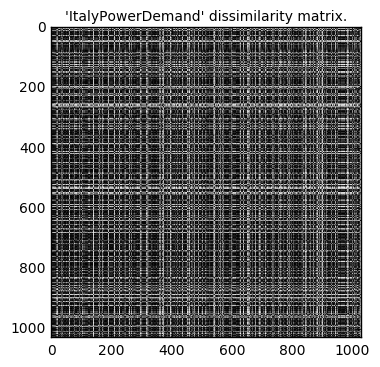

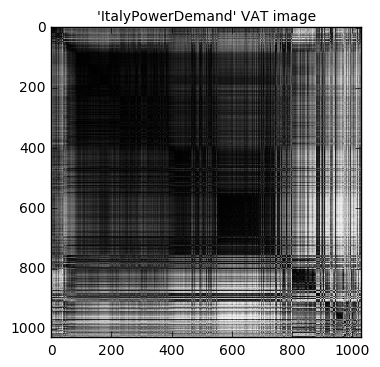

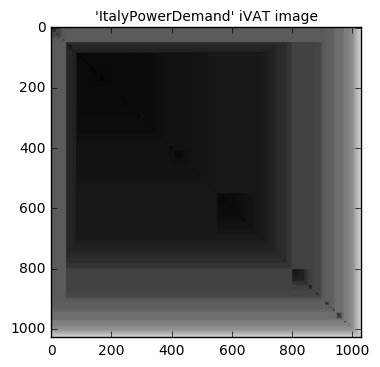

In [10]:
print('There are '+str(numSeries)+' series and '+str(lenSeries)+
      ' samples per series in the \''+datadirlist[setSelector]+'\' dataset.')

fig = figure(figsize=(4,4))
plt.plot(ts[:,1:].T);
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Value (arbitrary units)')
plt.title('\''+datadirlist[setSelector]+'\' dataset.',fontsize='medium')

fig = figure(figsize=(4,4))
plt.imshow(tsDissimMatrixSampled,cmap='Greys_r',interpolation='none');
plt.title('\''+datadirlist[setSelector]+'\' dissimilarity matrix.',fontsize='medium')

if save_pics: fig.savefig('./images/dismat_'
            +str(datadirlist[setSelector])+str(metric)+str(sampleRatio)+'.pdf'
            ,type='pdf',bbox_inches='tight')

fig = figure(figsize=(4,4))
plt.imshow(D_VAT,cmap='Greys_r',interpolation='none');
plt.title('\''+datadirlist[setSelector]+'\' VAT image',fontsize='medium')

if save_pics: fig.savefig('./images/VAT_'
            +str(datadirlist[setSelector])+str(metric)+str(sampleRatio)+'.pdf'
            ,type='pdf',bbox_inches='tight')

fig = figure(figsize=(4,4))
plt.imshow(D_iVAT,cmap='Greys_r',interpolation='none');
plt.title('\''+datadirlist[setSelector]+'\' iVAT image',fontsize='medium')

if save_pics: fig.savefig('./images/iVAT_'
            +str(datadirlist[setSelector])+str(metric)+str(sampleRatio)+'.pdf'
            ,type='pdf',bbox_inches='tight')

In [11]:
import pickle

f_iVAT = open('Results/'+datadirlist[setSelector]+'_'+metric+'_iVAT.csv','wb')
numpy.savetxt(f_iVAT,D_iVAT,delimiter=',')
f_iVAT.close()
fl_iVAT = open('Results/latest_VAT.csv','w')
numpy.savetxt(fl_iVAT,D_iVAT,delimiter=',')
fl_iVAT.close()

f_VAT = open('Results/'+datadirlist[setSelector]+'_'+metric+'_VAT.csv','wb')
numpy.savetxt(f_VAT,D_VAT,delimiter=',')
f_VAT.close()
fl_VAT = open('Results/latest_iVAT.csv','wb')
numpy.savetxt(fl_VAT,D_VAT,delimiter=',')
fl_VAT.close()

if clusiVATcheck and sampleRatio != 1.0:
    fl_disful = open('Results/latest_disful.csv','wb')
    numpy.savetxt(fl_disful,tsDissimMatrixFull,delimiter=',')
    fl_disful.close()

f_ind = open('Results/'+datadirlist[setSelector]+'_'+metric+'_ind.pickle','wb')
fl_ind = open('Results/latest_ind.pickle','wb')
pickle.dump(I_VAT,f_ind)
pickle.dump(I_VAT,fl_ind)
f_ind.close()
fl_ind.close()

f_sind = open('Results/'+datadirlist[setSelector]+'_'+metric+'_sind.pickle','wb')
fl_sind = open('Results/latest_sind.pickle','wb')
pickle.dump(sampleIndex,f_sind)
pickle.dump(sampleIndex,fl_sind)
f_sind.close()
fl_sind.close()

f_MSTC = open('Results/'+datadirlist[setSelector]+'_'+metric+'_MSTC.pickle','wb')
fl_MSTC = open('Results/latest_MSTC.pickle','wb')
pickle.dump(C,f_MSTC)
pickle.dump(C,fl_MSTC)
f_MSTC.close()
fl_MSTC.close()

f_MSTd = open('Results/'+datadirlist[setSelector]+'_'+metric+'_MSTd.pickle','wb')
fl_MSTd = open('Results/latest_MSTd.pickle','wb')
pickle.dump(d,f_MSTd)
pickle.dump(d,fl_MSTd)
f_MSTd.close()
fl_MSTd.close()

f_meta = open('Results/'+datadirlist[setSelector]+'_meta.pickle','wb')
fl_meta = open('Results/latest_meta.pickle','wb')
pickle.dump({'set': setSelector, 'sample ratio': sampleRatio, 'metric': metric},f_meta)
pickle.dump({'set': setSelector, 'sample ratio': sampleRatio, 'metric': metric},fl_meta)
f_meta.close()
fl_meta.close()

In [3]:
import pandas as pd

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y')

In [5]:

elec_dat = pd.read_csv('http://data.gov.au/dataset/0f3d60db-bd63-419e-9cd9-0a663f3abbc9/resource/9267e15e-1292-40fa-b6ef-3b41c9b95bd8/download/electricityconsumptionbenchmarkssurveydataaergovhack.csv',sep=',',parse_dates=[1], date_parser=dateparse)


In [6]:
elec_dat.head()

respondent OUTPUT_DATE     TYPE  E_0000_WH  E_0030_WH  E_0100_WH  \
0        8927  2012-04-01  general        426        396        340   
1        8927  2012-04-02  general       1872       1920       1620   
2        8927  2012-04-03  general        766        528        320   
3        8927  2012-04-04  general        696        546        408   
4        8927  2012-04-05  general        632        490        506   

   E_0130_WH  E_0200_WH  E_0230_WH  E_0300_WH    ...      E_1900_WH  \
0        392        348        378        362    ...            828   
1        304        230        268        198    ...            402   
2        474        384        338        326    ...            926   
3        390        362        384        186    ...            566   
4        330        364        308        352    ...            192   

   E_1930_WH  E_2000_WH  E_2030_WH  E_2100_WH  E_2130_WH  E_2200_WH  \
0        760        918        756        898       1228        710   
1        410        350        398        380       1018       1994   
2       1180       1122       1266        524        814        756   
3        456        418        406        354        592       1354   
4        218        172        528        950        982       1134   

   E_2230_WH  E_2300_WH  E_2330_WH  
0       1048        674       1528  
1       1584       1390       1018  
2       1610       1436        512  
3        970        874        850  
4        764        512        758  

[5 rows x 51 columns]

In [7]:
gendata = elec_dat.loc[elec_dat['TYPE']=='general',:]

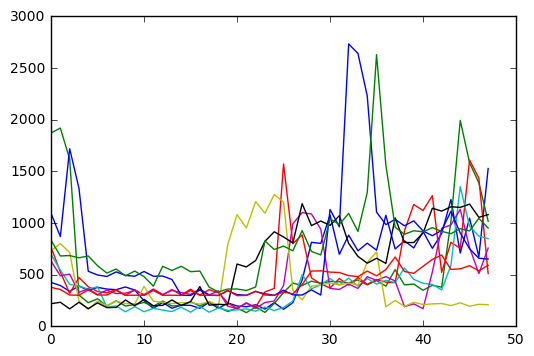

In [10]:
plt.plot(gendata.iloc[:10,3:].values.T);

In [11]:
grrp = gendata.groupby('OUTPUT_DATE')
fulldays = grrp.filter(lambda i: len(i)>24)
fgrp = fulldays.groupby('OUTPUT_DATE')
june = fgrp.filter(lambda i: i.name.month == 6)
jgrp = june.groupby('respondent')
jgrpavg = jgrp.mean()

[0, 24, None, None]

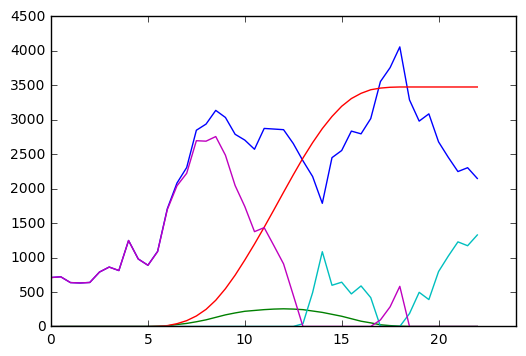

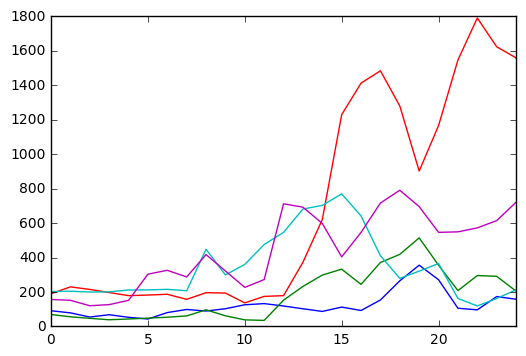

In [196]:
choice = numpy.random.choice(range(25), size=5, replace=False)
#choice = array([15,  9, 13,  3, 24])
time = np.array(range(45))/2.0
#time = time.reshape(len(time),1)
cumload = jgrpavg.iloc[choice,3:].sum(0).values
solcap = 400
solarcap = solcap*solar[:45]
solar_cum = np.array([0])
for i in range(1,len(solarcap)):
    solar_cum = np.append(solar_cum,[solarcap[i]+solar_cum[i-1]])
delta = solar_cum-cumload
deltapos = zeros(len(delta))
deltaneg = zeros(len(delta))
for i in range(len(delta)):
    if delta[i] >= 0:
        deltapos[i] = delta[i]
    else:
        deltaneg[i] = -delta[i]
figure()
plt.plot(time,cumload)
plt.plot(time,solarcap)
plt.plot(time,solar_cum)
plt.plot(time,deltapos)
plt.plot(time,deltaneg)
plt.axis([0,24,None,None])
figure()
plt.plot(jgrpavg.iloc[choice,3:].values.T);
plt.axis([0,24,None,None])

In [150]:
solar.shape

(49,)

In [142]:
solar = np.genfromtxt('Sheet3.csv', delimiter = ',')
solar = solar[:,1]

(48, 1)